# Predição de Séries Temporais com Redes Neurais Recorrentes

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, LSTM, SimpleRNN, GRU
from keras.callbacks import ModelCheckpoint
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import SimpleRNN, GRU
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Função para preparar os dados para o treinamento do modelo LSTM
def prepare_data(data, split_fraction, look_back):
    # Normalizando os dados
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(data)

    # Dividindo os dados em conjuntos de treinamento e teste
    train_size = int(len(data_scaled) * split_fraction)
    test_size = len(data_scaled) - train_size
    train, test = data_scaled[0:train_size,:], data_scaled[train_size:len(data_scaled),:]

    # Criando o gerador de séries temporais
    train_generator = TimeseriesGenerator(train, train, length=look_back, batch_size=20)
    test_generator = TimeseriesGenerator(test, test, length=look_back, batch_size=1)

    return train_generator, test_generator, scaler

In [3]:
# Função para construir e treinar o modelo LSTM
def build_and_train_model(train_generator, input_shape):
    # Construindo o modelo LSTM
    model = Sequential()
    model.add(LSTM(100, activation='relu', input_shape=input_shape))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')

    # Treinando o modelo
    model.fit_generator(train_generator, epochs=50)

    return model

In [4]:
def predict_and_inverse_transform(model, generator, scaler):
    predictions = model.predict_generator(generator)
    predictions = scaler.inverse_transform(predictions)
    return predictions

In [5]:
# Função para construir e treinar um modelo SimpleRNN
def build_and_train_simplernn_model(train_generator, input_shape):
    model = Sequential()
    model.add(SimpleRNN(50, input_shape=input_shape))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    model.fit_generator(train_generator, epochs=10)
    return model

In [6]:
# Função para construir e treinar um modelo GRU
def build_and_train_gru_model(train_generator, input_shape):
    model = Sequential()
    model.add(GRU(50, input_shape=input_shape))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    model.fit_generator(train_generator, epochs=10)
    return model

In [7]:
def train_ltsm(df_column):
    # Preparando os dados
    look_back = 12
    split_fraction = 0.8
    train_generator, test_generator, scaler = prepare_data(df_column.values.reshape(-1, 1), split_fraction, look_back)

    # Construindo e treinando o modelo LSTM
    model = build_and_train_model(train_generator, (look_back, 1))

    # Avaliando o modelo
    loss = model.evaluate_generator(test_generator)
    print('Test Loss: %.2f MSE' % (loss))
    
    return train_generator, test_generator, scaler, model, loss

In [8]:
def plot(df_column, model, test_generator, scaler, split_fraction=0.8, look_back=12):
    # Fazendo previsões
    predictions = predict_and_inverse_transform(model, test_generator, scaler)

    # Obtendo os valores reais
    real_values = df_column.values.reshape(-1, 1)
    real_values = real_values[int(split_fraction*len(real_values)) + look_back + 1:]

    # Plotando as previsões e os valores reais
    plt.figure(figsize=(16, 3))
    plt.plot(real_values, label='Real Values')
    plt.plot(predictions, label='Predicted Values')
    plt.legend()
    plt.show()

In [9]:
def plot_arima(real_values, predictions):
    # Fazendo previsões
    predictions = predictions

    # Plotando as previsões e os valores reais
    plt.figure(figsize=(16, 3))
    plt.plot(real_values.index, real_values.values, label='Real Values')
    plt.plot(predictions.index, predictions.values, label='Predicted Values')
    plt.legend()
    plt.show()

In [10]:
def train_arima(df):
    # Dividindo os dados em treinamento e teste
    train, test = train_test_split(df, test_size=0.2, shuffle=False)

    # Aplicando o AutoARIMA para determinar a ordem do modelo
    model = auto_arima(train, start_p=1, start_q=0, seasonal=False, trace=True)

    # Fazendo as previsões no conjunto de teste
    predictions = model.predict(n_periods=len(test))

    # Plotando as previsões
    plot_arima(test, predictions)

In [11]:
def train_sarima(df):
    # Dividindo os dados em treinamento e teste
    train, test = train_test_split(df, test_size=0.2, shuffle=False)

    # Aplicando o AutoARIMA para determinar a ordem do modelo
    model = auto_arima(train, start_p=0, start_q=0, seasonal=True, m=12, trace=True)

    # Fazendo as previsões no conjunto de teste
    predictions = model.predict(n_periods=len(test))

    # Plotando as previsões
    plot_arima(test, predictions)

In [12]:
look_back=12
split_fraction=0.8

# alcohol_sales

## eda

In [13]:
# Carregando os datasets
alcohol_sales = pd.read_csv('./data/Alcohol_Sales.csv')

Alcohol Sales Dataset:
         DATE  S4248SM144NCEN
0  1992-01-01            3459
1  1992-02-01            3458
2  1992-03-01            4002
3  1992-04-01            4564
4  1992-05-01            4221
       S4248SM144NCEN
count      325.000000
mean      7886.400000
std       2914.269061
min       3031.000000
25%       5231.000000
50%       7481.000000
75%       9977.000000
max      15504.000000


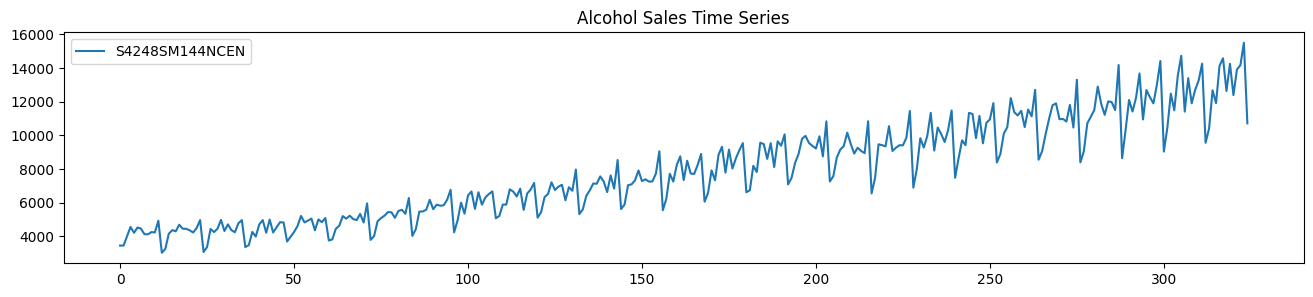

In [14]:
# Dataset alcohol_sales
print('Alcohol Sales Dataset:')
print(alcohol_sales.head())
print(alcohol_sales.describe())
plt.figure(figsize=(16, 3))
sns.lineplot(data=alcohol_sales)
plt.title('Alcohol Sales Time Series')
plt.show()

## lstm

Epoch 1/50
13/13 [==============================] - 1s 6ms/step - loss: 0.0677
Epoch 2/50
13/13 [==============================] - 0s 5ms/step - loss: 0.0118
Epoch 3/50
13/13 [==============================] - 0s 5ms/step - loss: 0.0089
Epoch 4/50
13/13 [==============================] - 0s 5ms/step - loss: 0.0082
Epoch 5/50
13/13 [==============================] - 0s 5ms/step - loss: 0.0064
Epoch 6/50
13/13 [==============================] - 0s 7ms/step - loss: 0.0052
Epoch 7/50
13/13 [==============================] - 0s 5ms/step - loss: 0.0050
Epoch 8/50
13/13 [==============================] - 0s 5ms/step - loss: 0.0047
Epoch 9/50
13/13 [==============================] - 0s 5ms/step - loss: 0.0046
Epoch 10/50
13/13 [==============================] - 0s 5ms/step - loss: 0.0046
Epoch 11/50
13/13 [==============================] - 0s 4ms/step - loss: 0.0047
Epoch 12/50
13/13 [==============================] - 0s 5ms/step - loss: 0.0046
Epoch 13/50
13/13 [==============================

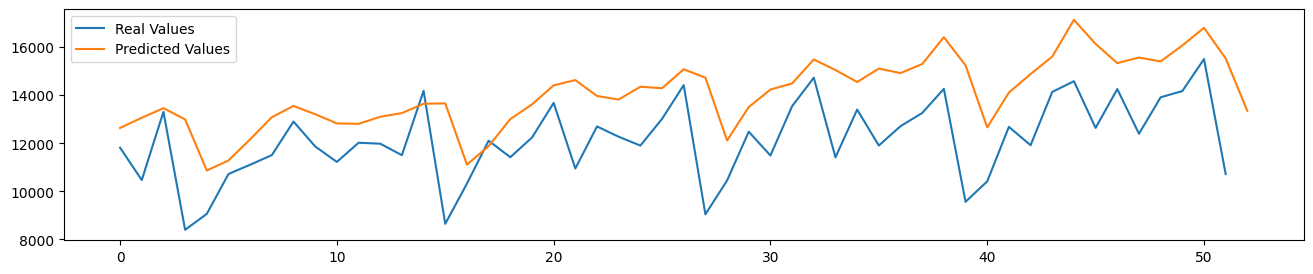

In [15]:
train_generator, test_generator, scaler, model, loss = train_ltsm(alcohol_sales['S4248SM144NCEN'])
plot(alcohol_sales['S4248SM144NCEN'], model, test_generator, scaler)

## simplern

Epoch 1/10
13/13 [==============================] - 1s 2ms/step - loss: 0.0896
Epoch 2/10
13/13 [==============================] - 0s 2ms/step - loss: 0.0103
Epoch 3/10
13/13 [==============================] - 0s 2ms/step - loss: 0.0047
Epoch 4/10
13/13 [==============================] - 0s 3ms/step - loss: 0.0039
Epoch 5/10
13/13 [==============================] - 0s 3ms/step - loss: 0.0032
Epoch 6/10
13/13 [==============================] - 0s 3ms/step - loss: 0.0026
Epoch 7/10
13/13 [==============================] - 0s 7ms/step - loss: 0.0022
Epoch 8/10
13/13 [==============================] - 0s 2ms/step - loss: 0.0020
Epoch 9/10
13/13 [==============================] - 0s 2ms/step - loss: 0.0017
Epoch 10/10
13/13 [==============================] - 0s 2ms/step - loss: 0.0017
Test Loss for SimpleRNN: 0.01 MSE


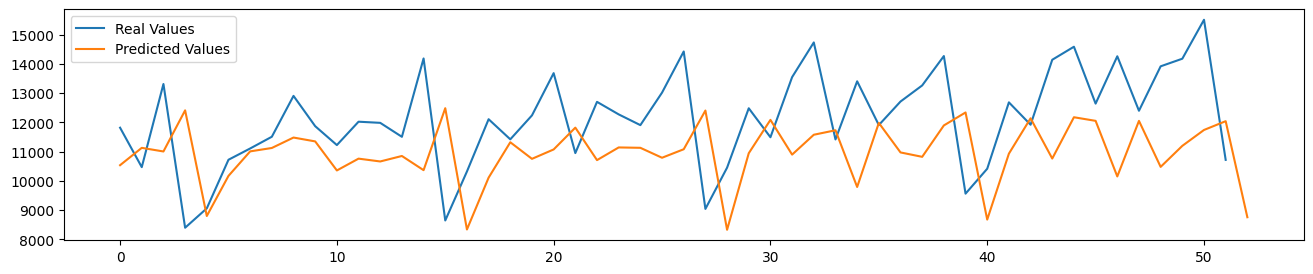

In [16]:
# Construindo e treinando o modelo SimpleRNN
simplernn_model = build_and_train_simplernn_model(train_generator, (look_back, 1))

# Avaliando o modelo
loss = simplernn_model.evaluate_generator(test_generator)
print('Test Loss for SimpleRNN: %.2f MSE' % (loss))

plot(alcohol_sales['S4248SM144NCEN'], simplernn_model, test_generator, scaler)

## gru

Epoch 1/10
13/13 [==============================] - 2s 5ms/step - loss: 0.0582
Epoch 2/10
13/13 [==============================] - 0s 3ms/step - loss: 0.0164
Epoch 3/10
13/13 [==============================] - 0s 3ms/step - loss: 0.0127
Epoch 4/10
13/13 [==============================] - 0s 4ms/step - loss: 0.0101
Epoch 5/10
13/13 [==============================] - 0s 4ms/step - loss: 0.0091
Epoch 6/10
13/13 [==============================] - 0s 4ms/step - loss: 0.0075
Epoch 7/10
13/13 [==============================] - 0s 4ms/step - loss: 0.0067
Epoch 8/10
13/13 [==============================] - 0s 4ms/step - loss: 0.0060
Epoch 9/10
13/13 [==============================] - 0s 4ms/step - loss: 0.0056
Epoch 10/10
13/13 [==============================] - 0s 4ms/step - loss: 0.0054
Test Loss for GRU: 0.02 MSE


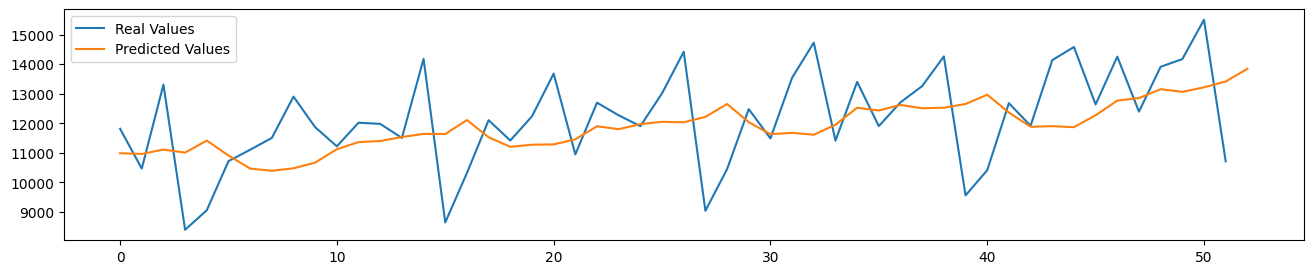

In [17]:
# Construindo e treinando o modelo GRU
gru_model = build_and_train_gru_model(train_generator, (look_back, 1))

# Avaliando o modelo
loss = gru_model.evaluate_generator(test_generator)
print('Test Loss for GRU: %.2f MSE' % (loss))

plot(alcohol_sales['S4248SM144NCEN'], gru_model, test_generator, scaler)

## arima

Performing stepwise search to minimize aic
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4320.812, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4361.815, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4231.511, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4360.025, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4229.397, Time=0.20 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4229.779, Time=0.32 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.31 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4228.707, Time=0.21 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4229.300, Time=0.39 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.45 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4251.238, Time=0.03 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 2.061 seconds


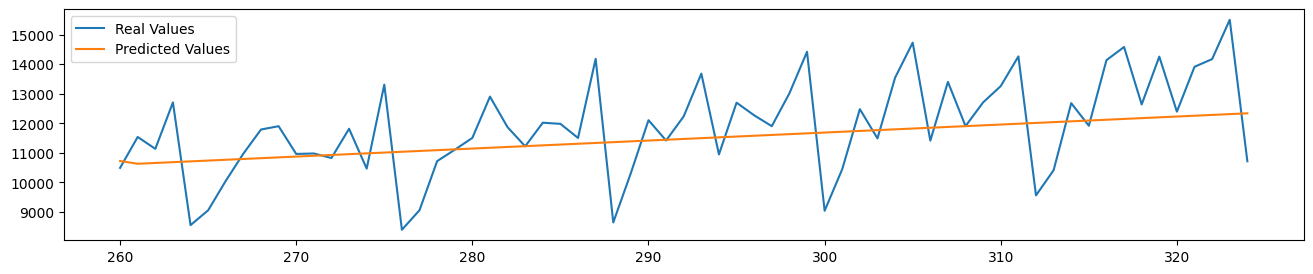

In [18]:
train_arima(alcohol_sales['S4248SM144NCEN']) 


## sarima

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=3774.944, Time=0.39 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=3796.917, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=3693.610, Time=0.09 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=3595.547, Time=0.53 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=3597.694, Time=0.13 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=3578.580, Time=0.62 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=3597.788, Time=0.35 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=3522.893, Time=1.84 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=3569.585, Time=1.15 sec
 ARIMA(0,1,1)(2,1,2)[12]             : AIC=inf, Time=3.42 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=3552.808, Time=2.20 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=3673.162, Time=1.55 sec
 ARIMA(1,1,1)(2,1,1)[12]             : AIC=3520.869, Time=2.32 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=3557.625, Time=1.10 sec
 ARIMA(1,1,1)(2,1,0)[12]

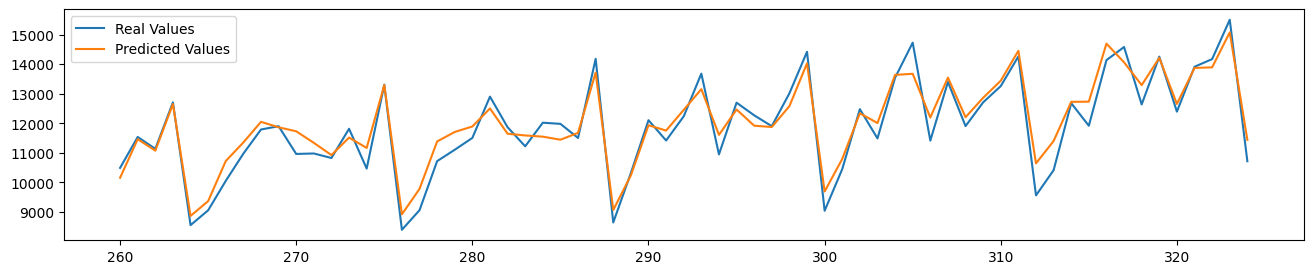

In [19]:
train_sarima(alcohol_sales['S4248SM144NCEN']) 

# beer_wine_liquor

## eda

In [20]:
beer_wine_liquor = pd.read_csv('./data/BeerWineLiquor.csv')

Beer Wine Liquor Dataset:
       date  beer
0  1/1/1992  1509
1  2/1/1992  1541
2  3/1/1992  1597
3  4/1/1992  1675
4  5/1/1992  1822
              beer
count   324.000000
mean   2972.895062
std    1010.218574
min    1501.000000
25%    2109.000000
50%    2791.000000
75%    3627.250000
max    6370.000000


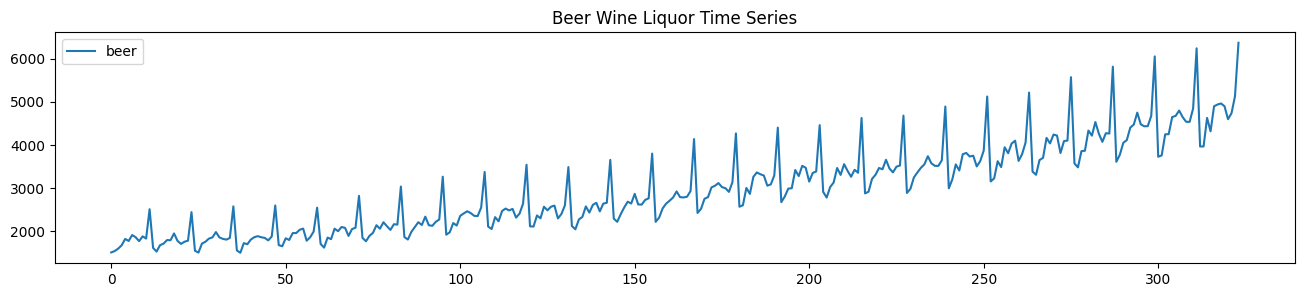

In [21]:
# Dataset beer_wine_liquor
print('Beer Wine Liquor Dataset:')
print(beer_wine_liquor.head())
print(beer_wine_liquor.describe())
plt.figure(figsize=(16, 3))
sns.lineplot(data=beer_wine_liquor)
plt.title('Beer Wine Liquor Time Series')
plt.show()

## ltsm

Epoch 1/50
13/13 [==============================] - 1s 6ms/step - loss: 0.0602
Epoch 2/50
13/13 [==============================] - 0s 6ms/step - loss: 0.0233
Epoch 3/50
13/13 [==============================] - 0s 4ms/step - loss: 0.0133
Epoch 4/50
13/13 [==============================] - 0s 5ms/step - loss: 0.0104
Epoch 5/50
13/13 [==============================] - 0s 5ms/step - loss: 0.0084
Epoch 6/50
13/13 [==============================] - 0s 5ms/step - loss: 0.0075
Epoch 7/50
13/13 [==============================] - 0s 5ms/step - loss: 0.0064
Epoch 8/50
13/13 [==============================] - 0s 5ms/step - loss: 0.0060
Epoch 9/50
13/13 [==============================] - 0s 5ms/step - loss: 0.0058
Epoch 10/50
13/13 [==============================] - 0s 5ms/step - loss: 0.0057
Epoch 11/50
13/13 [==============================] - 0s 5ms/step - loss: 0.0057
Epoch 12/50
13/13 [==============================] - 0s 5ms/step - loss: 0.0055
Epoch 13/50
13/13 [==============================

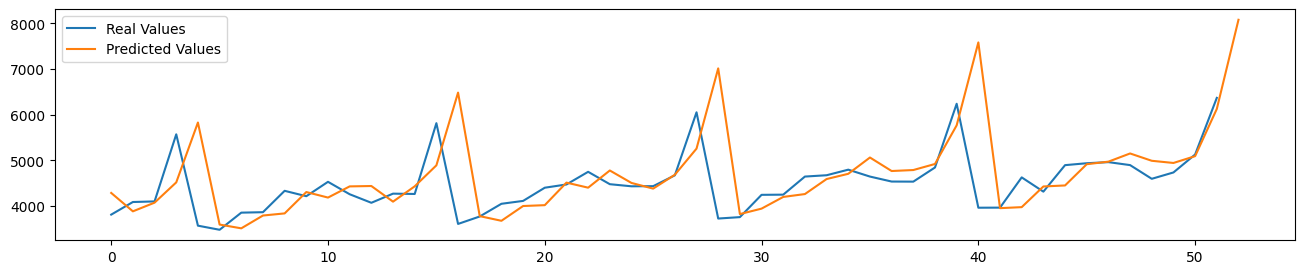

In [22]:
train_generator, test_generator, scaler, model, loss = train_ltsm(beer_wine_liquor['beer'])
plot(beer_wine_liquor['beer'], model, test_generator, scaler)

## simplernn

Epoch 1/10
13/13 [==============================] - 1s 2ms/step - loss: 0.0057
Epoch 2/10
13/13 [==============================] - 0s 2ms/step - loss: 0.0030
Epoch 3/10
13/13 [==============================] - 0s 2ms/step - loss: 0.0016
Epoch 4/10
13/13 [==============================] - 0s 2ms/step - loss: 0.0013
Epoch 5/10
13/13 [==============================] - 0s 2ms/step - loss: 7.5603e-04
Epoch 6/10
13/13 [==============================] - 0s 2ms/step - loss: 8.0259e-04
Epoch 7/10
13/13 [==============================] - 0s 2ms/step - loss: 8.6393e-04
Epoch 8/10
13/13 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 9/10
13/13 [==============================] - 0s 2ms/step - loss: 5.5844e-04
Epoch 10/10
13/13 [==============================] - 0s 2ms/step - loss: 4.6056e-04
Test Loss for SimpleRNN: 0.01 MSE


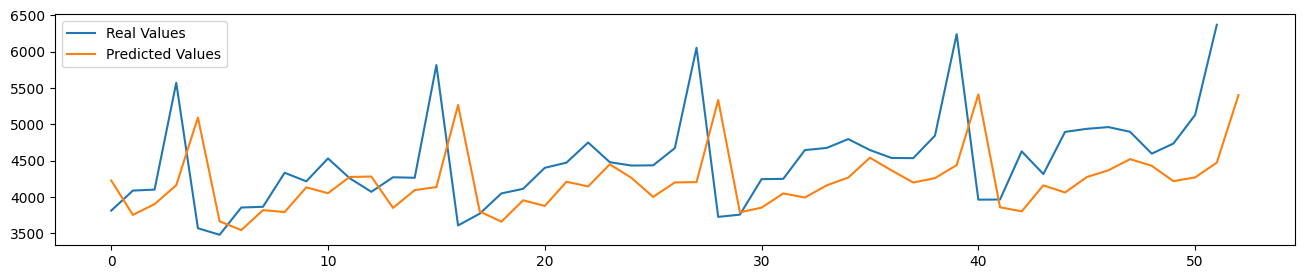

In [23]:
# Construindo e treinando o modelo SimpleRNN
simplernn_model = build_and_train_simplernn_model(train_generator, (look_back, 1))

# Avaliando o modelo
loss = simplernn_model.evaluate_generator(test_generator)
print('Test Loss for SimpleRNN: %.2f MSE' % (loss))

plot(beer_wine_liquor['beer'], simplernn_model, test_generator, scaler)

## gru

Epoch 1/10
13/13 [==============================] - 1s 4ms/step - loss: 0.0417
Epoch 2/10
13/13 [==============================] - 0s 4ms/step - loss: 0.0111
Epoch 3/10
13/13 [==============================] - 0s 4ms/step - loss: 0.0111
Epoch 4/10
13/13 [==============================] - 0s 4ms/step - loss: 0.0092
Epoch 5/10
13/13 [==============================] - 0s 4ms/step - loss: 0.0083
Epoch 6/10
13/13 [==============================] - 0s 4ms/step - loss: 0.0075
Epoch 7/10
13/13 [==============================] - 0s 4ms/step - loss: 0.0068
Epoch 8/10
13/13 [==============================] - 0s 4ms/step - loss: 0.0065
Epoch 9/10
13/13 [==============================] - 0s 4ms/step - loss: 0.0064
Epoch 10/10
13/13 [==============================] - 0s 3ms/step - loss: 0.0065
Test Loss for GRU: 0.02 MSE


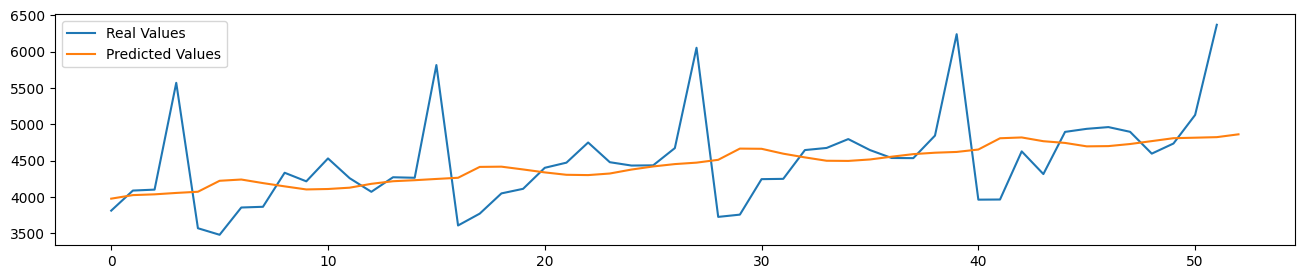

In [24]:
# Construindo e treinando o modelo GRU
gru_model = build_and_train_gru_model(train_generator, (look_back, 1))

# Avaliando o modelo
loss = gru_model.evaluate_generator(test_generator)
print('Test Loss for GRU: %.2f MSE' % (loss))

plot(beer_wine_liquor['beer'], gru_model, test_generator, scaler)

## arima

Performing stepwise search to minimize aic
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3909.219, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3957.777, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3784.532, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3955.872, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3786.261, Time=0.22 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.29 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3803.670, Time=0.04 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 0.902 seconds


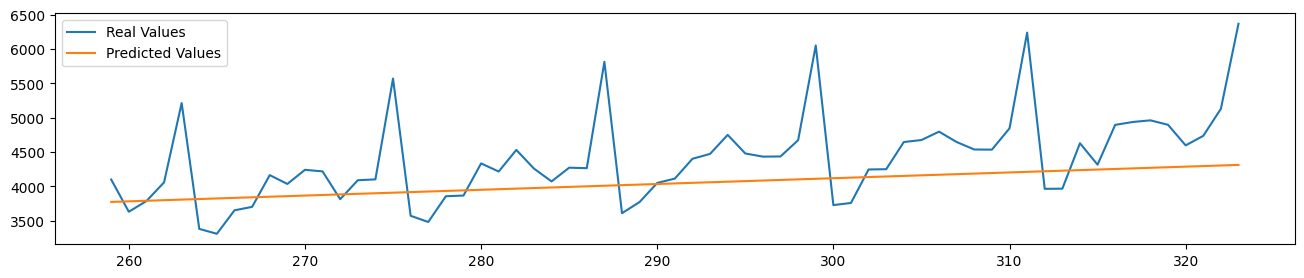

In [25]:
train_arima(beer_wine_liquor['beer']) 

## sarima

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=2981.686, Time=0.32 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=2995.175, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=2905.820, Time=0.16 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=2855.609, Time=0.21 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=2867.236, Time=0.05 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=2847.176, Time=0.45 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=2862.054, Time=0.20 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=2843.624, Time=1.35 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=2858.262, Time=0.65 sec
 ARIMA(0,1,1)(2,1,2)[12]             : AIC=inf, Time=2.61 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=2847.047, Time=1.38 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=2960.766, Time=1.11 sec
 ARIMA(1,1,1)(2,1,1)[12]             : AIC=2839.905, Time=1.71 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=2841.687, Time=0.60 sec
 ARIMA(1,1,1)(2,1,0)[12]

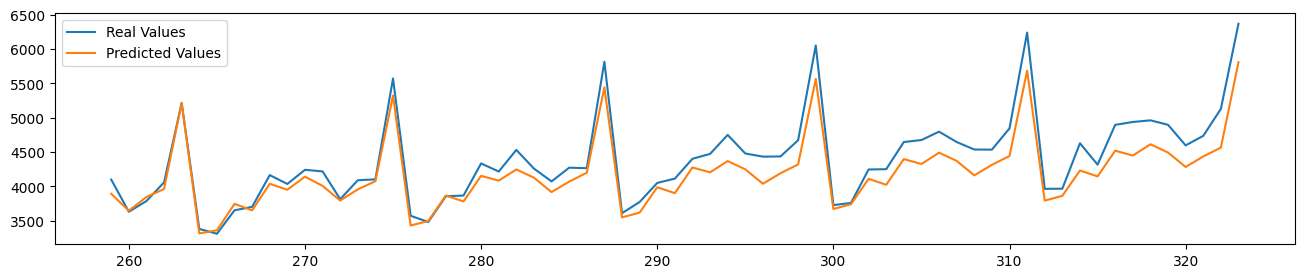

In [26]:
train_sarima(beer_wine_liquor['beer']) 

# miles_traveled

## eda

In [27]:
miles_traveled = pd.read_csv('./data/Miles_Traveled.csv')

Miles Traveled Dataset:
         DATE  TRFVOLUSM227NFWA
0  1970-01-01           80173.0
1  1970-02-01           77442.0
2  1970-03-01           90223.0
3  1970-04-01           89956.0
4  1970-05-01           97972.0
       TRFVOLUSM227NFWA
count        588.000000
mean      190420.380952
std        57795.538934
min        77442.000000
25%       133579.000000
50%       196797.500000
75%       243211.500000
max       288145.000000


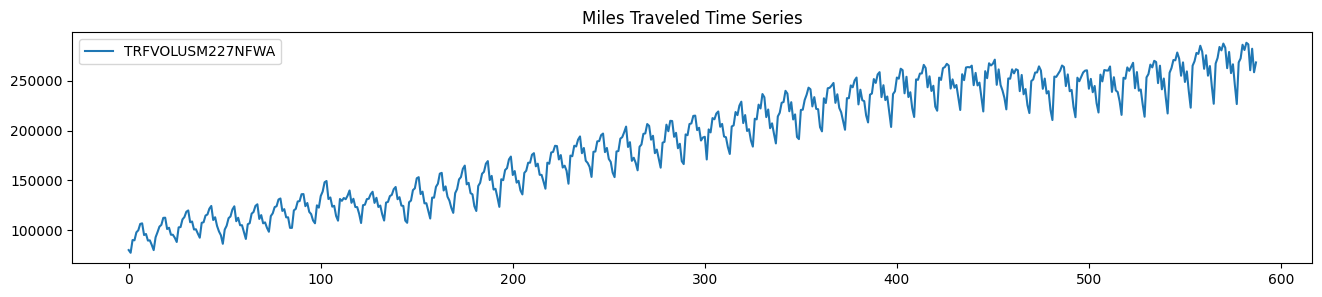

In [28]:
# Dataset miles_traveled
print('Miles Traveled Dataset:')
print(miles_traveled.head())
print(miles_traveled.describe())
plt.figure(figsize=(16, 3))
sns.lineplot(data=miles_traveled)
plt.title('Miles Traveled Time Series')
plt.show()

## ltsm

Epoch 1/50
23/23 [==============================] - 1s 7ms/step - loss: 0.0782
Epoch 2/50
23/23 [==============================] - 0s 7ms/step - loss: 0.0096
Epoch 3/50
23/23 [==============================] - 0s 7ms/step - loss: 0.0052
Epoch 4/50
23/23 [==============================] - 0s 6ms/step - loss: 0.0046
Epoch 5/50
23/23 [==============================] - 0s 7ms/step - loss: 0.0042
Epoch 6/50
23/23 [==============================] - 0s 7ms/step - loss: 0.0042
Epoch 7/50
23/23 [==============================] - 0s 6ms/step - loss: 0.0042
Epoch 8/50
23/23 [==============================] - 0s 6ms/step - loss: 0.0040
Epoch 9/50
23/23 [==============================] - 0s 7ms/step - loss: 0.0037
Epoch 10/50
23/23 [==============================] - 0s 7ms/step - loss: 0.0039
Epoch 11/50
23/23 [==============================] - 0s 8ms/step - loss: 0.0035
Epoch 12/50
23/23 [==============================] - 0s 7ms/step - loss: 0.0035
Epoch 13/50
23/23 [==============================

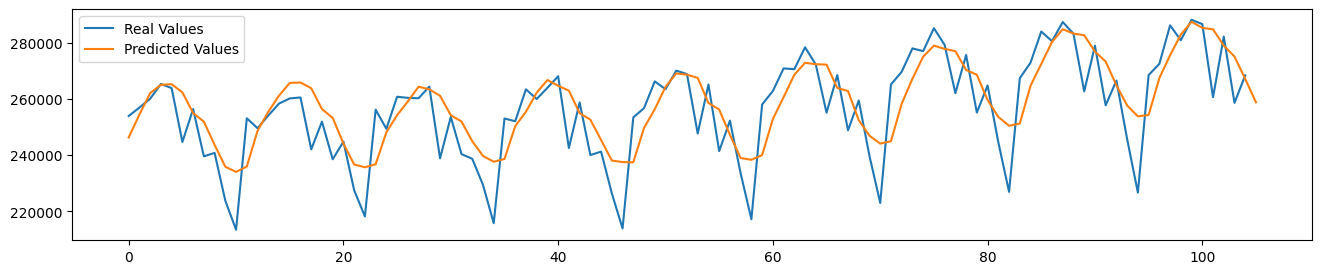

In [29]:
train_generator, test_generator, scaler, model, loss = train_ltsm(miles_traveled['TRFVOLUSM227NFWA'])
plot(miles_traveled['TRFVOLUSM227NFWA'], model, test_generator, scaler)

## simplernn

## gru

Epoch 1/10
23/23 [==============================] - 1s 4ms/step - loss: 0.0785
Epoch 2/10
23/23 [==============================] - 0s 3ms/step - loss: 0.0172
Epoch 3/10
23/23 [==============================] - 0s 4ms/step - loss: 0.0108
Epoch 4/10
23/23 [==============================] - 0s 4ms/step - loss: 0.0070
Epoch 5/10
23/23 [==============================] - 0s 4ms/step - loss: 0.0054
Epoch 6/10
23/23 [==============================] - 0s 4ms/step - loss: 0.0048
Epoch 7/10
23/23 [==============================] - 0s 4ms/step - loss: 0.0043
Epoch 8/10
23/23 [==============================] - 0s 4ms/step - loss: 0.0041
Epoch 9/10
23/23 [==============================] - 0s 4ms/step - loss: 0.0040
Epoch 10/10
23/23 [==============================] - 0s 4ms/step - loss: 0.0038
Test Loss for GRU: 0.01 MSE


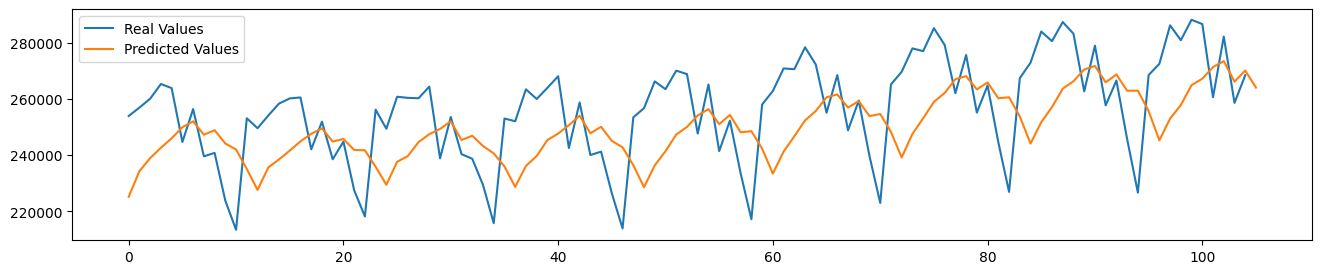

In [30]:
# Construindo e treinando o modelo GRU
gru_model = build_and_train_gru_model(train_generator, (look_back, 1))

# Avaliando o modelo
loss = gru_model.evaluate_generator(test_generator)
print('Test Loss for GRU: %.2f MSE' % (loss))

plot(miles_traveled['TRFVOLUSM227NFWA'], gru_model, test_generator, scaler)

## arima

Performing stepwise search to minimize aic
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=10078.673, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=10102.105, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=10085.259, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=10100.412, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=10068.371, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=10067.537, Time=0.06 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=10035.136, Time=0.09 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=10030.844, Time=0.12 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=9917.922, Time=0.27 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=9935.208, Time=0.30 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=9916.947, Time=0.79 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=9916.256, Time=0.69 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.67 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=9775.256, Time=0.78 sec
 ARIMA(3,1,3)(0,0,0)[0] interc

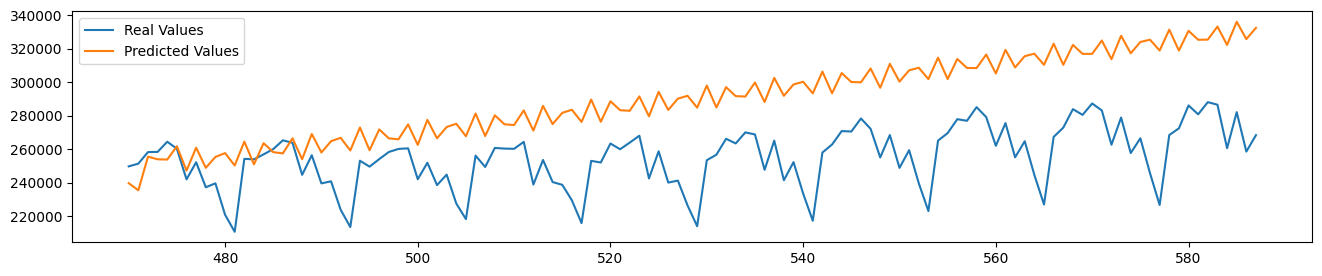

In [31]:
train_arima(miles_traveled['TRFVOLUSM227NFWA']) 

## sarima

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=9407.645, Time=1.11 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=10102.105, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=9323.587, Time=0.76 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=9712.504, Time=0.44 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=10100.412, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=10078.673, Time=0.03 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=inf, Time=2.97 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=9416.209, Time=1.42 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=9828.721, Time=0.16 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=9332.657, Time=2.64 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=9351.000, Time=0.54 sec
 ARIMA(2,1,0)(1,0,0)[12] intercept   : AIC=inf, Time=nan sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=9534.403, Time=0.79 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=9320.111, Time=0.91 sec
 ARIMA(0,1,1)(0,0,0)[12] in

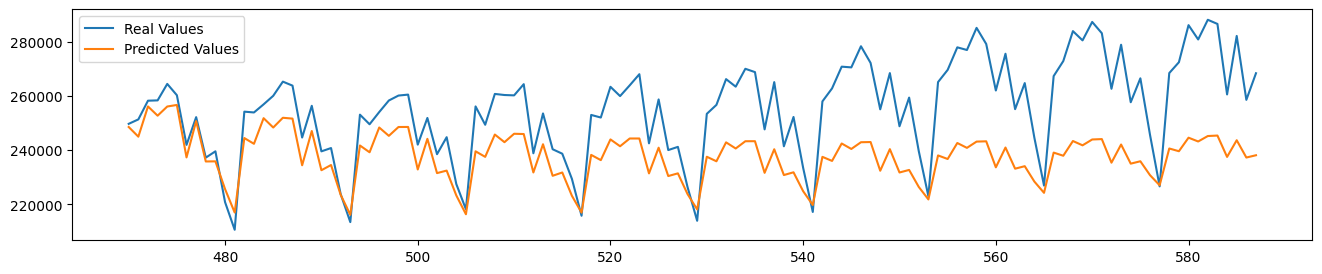

In [32]:
train_sarima(miles_traveled['TRFVOLUSM227NFWA']) 